# Near Miss Development: V5
- Fix DTW to account for length dependency of sequence comparisonss (i.e. comparing a sequence to a longer sequence will inherently give you a longer time series)
- Fix DTW to make sure inputs are z-normalized before

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import time

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

PLACE_HOLDER = None

## Begin Near Miss Development Here:

#### Function IO

In [2]:
def near_miss_v5(x, y, k, r=3, scale_weight=1):
    """
    Parameters:
    x : numpy array
        Long time series data
    y : numpy array
        Query sequence
    k : int
        Size of pieces
    r : int
        Size of neighborhood when expanding the path. A higher value will
        increase the accuracy of the calculation but also increase time
        and memory consumption. A radius equal to the size of x and y will
        yield an exact dynamic time warping calculation.
    scale_weight : int
        Weight to apply to the scale penalty. A higher value will increase
        the penalty for scale changes. A value of 0 will ignore the scale
        penalty.
    Returns:
    dist : numpy array
        DTW-based distance profile with scale penalty
    """

# Development V4 Objective:
- Implement some additional contributions to the method

#### Near Miss Algorithm:

In [42]:
def near_miss_v5(x, y, r=10, scale_weight=0):
    n = len(x)
    m = len(y)
    half_m = m // 2  # Half the length of the query
    expected_length = n - m + 1
    dist = []

    k = determine_k(n, m)

    y_norm = z_normalize(y)

    # Loop through the time series x with varying segment lengths
    for j in range(0, n - m + 1, k):
        segment_lengths = range(m - half_m, m + half_m + 1)
        best_distance = float('inf')

        for seg_len in segment_lengths:
            if j + seg_len <= n:
                segment = x[j:j + seg_len]
                segment_norm = z_normalize(segment)

                # Compute DTW distance and path
                distance, path = fastdtw(segment_norm, y_norm, r)

                # Normalize the distance by warping path length
                path_length = len(path)
                normalized_distance = distance / path_length

                # Compute scale penalty if sequences are not normalized
                scale_penalty = compute_scale_penalty(segment, y)
                total_distance = normalized_distance + scale_weight * scale_penalty

                # Keep the best distance for this starting point
                if total_distance < best_distance:
                    best_distance = total_distance

        # Append the best distance found for this position
        dist.append(best_distance)

    # Ensure consistent length
    dist = np.array(dist)
    if len(dist) > expected_length:
        dist = dist[:expected_length]
    elif len(dist) < expected_length:
        dist = np.pad(dist, (0, expected_length - len(dist)), 'constant', constant_values=np.nan)

    return dist


### Z - Normalization

In [16]:
def z_normalize(ts):
    return (ts - np.mean(ts)) / np.std(ts)

### Scale Penalty Function

In [36]:
def compute_scale_penalty(subsequence, query_sequence):
    """
    Computes the scale penalty based on the difference in scale (mean and std deviation)
    between a subsequence and the query sequence.

    Parameters:
    ----------
    subsequence : numpy array
        A subsequence of the longer time series.
    query_sequence : numpy array
        The query time series.

    Returns:
    -------
    scale_penalty : float
        A penalty value based on the scale difference between the two sequences.
    """
    # Calculate the length of the subsequence
    len_subsequence = len(subsequence)

    # Calculate mean and standard deviation of both sequences
    mean_subsequence = np.mean(subsequence)
    mean_query = np.mean(query_sequence)
    # std_subsequence = np.std(subsequence)
    # std_query = np.std(query_sequence)
    
    # Compute penalty as the absolute difference in means and standard deviations
    mean_diff = abs(mean_subsequence - mean_query)
    # std_diff = abs(std_subsequence - std_query)
    
    scale_penalty = mean_diff # mean_diff
    
    return scale_penalty

### Function for determining the optimal value for k (number of pieces):

In [18]:
def determine_k(n, m):
    """
    Determines the optimal value of k for MASS V3.
    
    Parameters:
    n : Length of the time series (int) 
    m : Length of the query (int)

    Returns:
    k : Optimal segment size, preferably a power of two (int)
    """
    # Set k to be the next power of two greater than or equal to 4 times the query length
    k = 2 ** int(np.ceil(np.log2(max(4 * m, m))))
    # Ensure k is not greater than the length of the time series
    k = min(k, n)
    return k

## Test Implementation

In [8]:
# Load the query and trip data (1 query and 1 trip)
x = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\x_trip_5109.csv')
y = pd.read_csv(r'C:\Users\donav\OneDrive\Desktop\Gatech\Research\GRA Ford Research\Near Miss Algorithm Development\data\y_query_7.csv')


In [9]:
# Determine the optimal segment size
n = len(x)
m = len(y)
k = determine_k(n, m)

In [10]:
# The initial columns to compare in the time series data
columns = ['veh_long_vel_mps', 'veh_accel_mps2_analytical', 'veh_ltrl_vel_mps', 'veh_yaw_rate_radps', 'veh_jerk_mps3_analytical']

In [11]:
# Set the radius for the DTW calculation
r = 3

Test Description: This test is for Near Miss algorithm v5 implementation


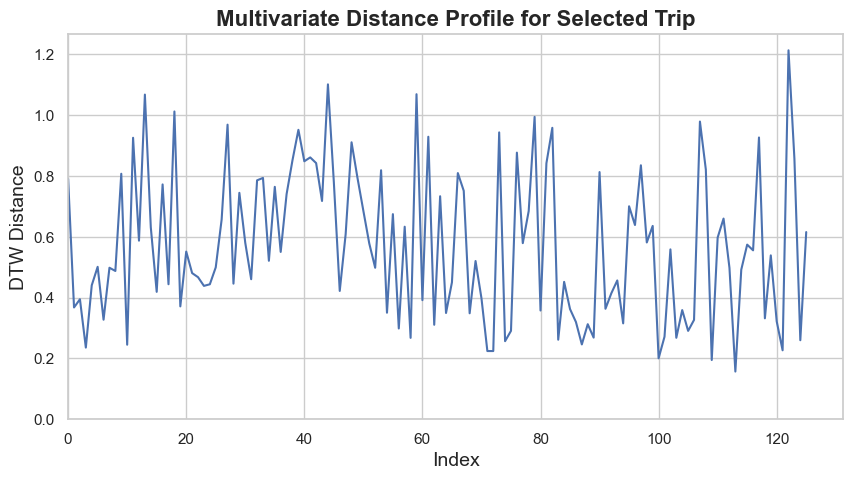

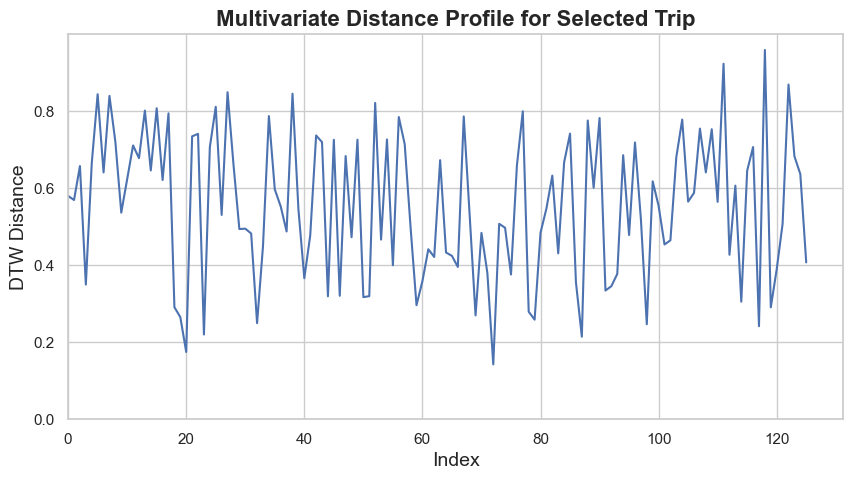

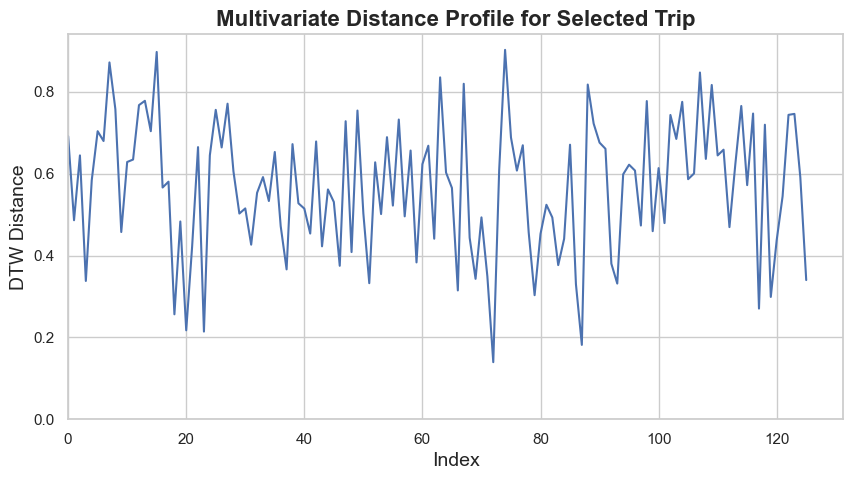

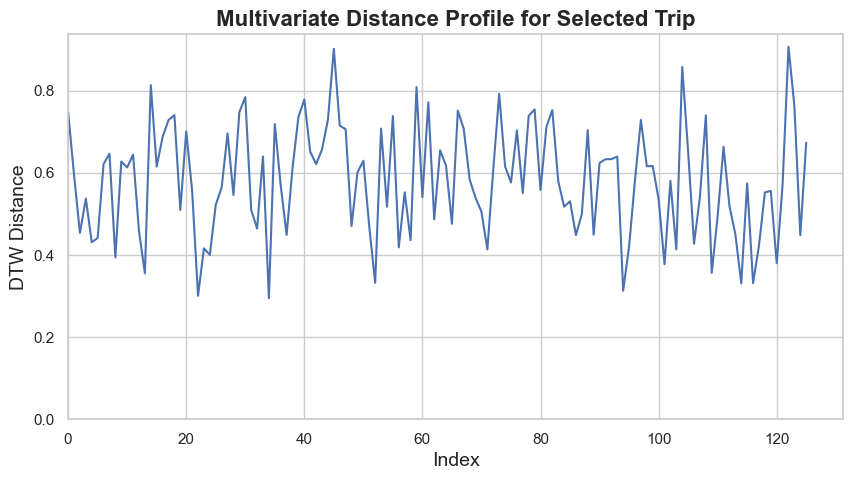

Time taken: 2.969278573989868 seconds


In [43]:
print("Test Description: This test is for Near Miss algorithm v5 implementation")

start_time = time.time()

combined_distance_profile = near_miss_v5(x[columns[0]].values, y[columns[0]].values)  # Initialize combined distance profile

# Loop through each column and compute the distance profile
for col in columns:
    if col == columns[0]:
        continue
    distance_profile = near_miss_v5(x[col].values, y[col].values)
    plot_distance_profile(distance_profile)
    combined_distance_profile += distance_profile  # Sum the distance profiles

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

# Analysis
- What does this new distance profile look like?

In [28]:
# Plot Distance Profile Function using seaborn
def plot_distance_profile(distance_profile):
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=distance_profile)
    plt.title(f'Multivariate Distance Profile for Selected Trip', fontsize=16, fontweight='bold')
    plt.xlabel('Index', fontsize=14)
    plt.ylabel('DTW Distance', fontsize=14)
    plt.grid(True)
    plt.xlim(left=0)  # Ensure x-axis starts at 0
    plt.ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.show()

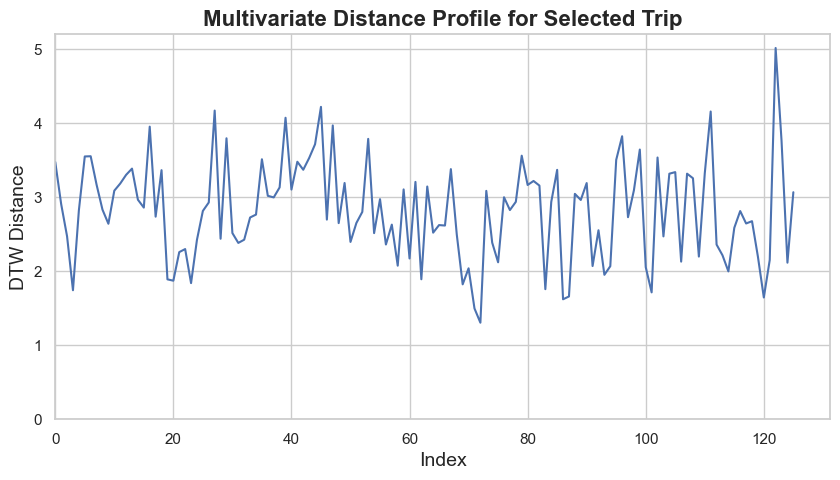

In [44]:
# Plot the combined distance profile
plot_distance_profile(combined_distance_profile)